In [9]:
# Import the necessary libraries, including pyodbc and pandas
import pyodbc
import pandas as pd
import os
import re
from datetime import datetime

# Preparations

## Installations

In [36]:
# Install the necessary libraries using pip

# !pip install pyodbc pandas
# !brew install graphviz
# !pip install graphviz

## Set Up Database Connection

In [3]:
def get_linux_password(env_file):
    env_file = os.path.expanduser(env_file)
    with open(env_file, "r") as file:
        for line in file:
            match = re.match(r"LINUX_PASSWORD='''(.+)'''", line)
            if match:
                return match.group(1)
    return None

db_password = get_linux_password("~/.bitwarden1.env")


In [4]:
! echo "check if VPN is connected..."
! scutil --nc status "VPN" | head -n 1 | grep Connected || (echo "❌ VPN is not connected!")

# Define the connection string
connection_string = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=10.213.254.250\\TEST01;"
    "DATABASE=ITST_Test_1;"
    "UID=sa;"
    f"PWD={db_password}"
)

# Establish the connection
connection = pyodbc.connect(connection_string)

# Verify the connection by printing the server name
cursor = connection.cursor()
cursor.execute("SELECT @@SERVERNAME")
server_name = cursor.fetchone()[0]
print(f"Connected to server: {server_name}")


check if VPN is connected...
Connected
Connected to server: LAB-SQL-01\TEST01


In [5]:
# cursor.close()
# connection.close()

In [12]:
# Execute a Simple Query
def run_query(query):    
    start_time = datetime.now()
    print(query)
    # Execute a simple SQL query
    cursor.execute(query)
    
    # Fetch the results
    results = cursor.fetchall()
    
    # Convert the results to a pandas DataFrame
    df = pd.DataFrame.from_records(results, columns=[column[0] for column in cursor.description])
    end_time = datetime.now()
    print(f"took {end_time - start_time}")
    return df

In [13]:
run_query("SELECT TOP 10 * FROM INFORMATION_SCHEMA.TABLES")

SELECT TOP 10 * FROM INFORMATION_SCHEMA.TABLES
took 0:00:00.186873


,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,ITST_Test_1,dbo,IdRanges,BASE TABLE
1,ITST_Test_1,dbo,UserOAuthAccessTokens,BASE TABLE
2,ITST_Test_1,dbo,Projects,BASE TABLE
3,ITST_Test_1,dbo,ProjectIpRestrictions,BASE TABLE
4,ITST_Test_1,dbo,PredictorTrainings,BASE TABLE
5,ITST_Test_1,dbo,Splunk_User_TemplateType,VIEW
6,ITST_Test_1,dbo,env_w_storage_issue,BASE TABLE
7,ITST_Test_1,dbo,CourseStages,BASE TABLE
8,ITST_Test_1,dbo,UserFeatureViews,BASE TABLE
9,ITST_Test_1,dbo,WebHookSubscriptions,BASE TABLE


# Check long qureis


In [20]:
import pyodbc
import pandas as pd
from datetime import datetime

def run_query(query, connection):
    start_time = datetime.now()
    print(query)

    # Create a new cursor
    cursor = connection.cursor()

    # Split query by 'GO' (if it exists)
    queries = query.split("GO")

    for q in queries:
        q = q.strip()
        if q:  # Ignore empty queries
            cursor.execute(q)
    
    # Fetch results only for the last executed query
    results = cursor.fetchall()
    df = pd.DataFrame.from_records(results, columns=[column[0] for column in cursor.description])
    
    end_time = datetime.now()
    print(f"took {end_time - start_time}")
    
    return df

# Establish the connection
connection_string = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=10.213.254.250\\TEST01;"
    "DATABASE=ITST_Test_1;"
    "UID=sa;"
    f"PWD={db_password}"
)
connection = pyodbc.connect(connection_string)

# Run the query
query = """
SET SHOWPLAN_TEXT ON;
SELECT TOP 10 Hostname FROM BackendMachines WHERE LifecycleStatusInt=1;
SET SHOWPLAN_TEXT OFF;
"""

df = run_query(query, connection)
print(df)



SET SHOWPLAN_TEXT ON;
SELECT TOP 10 Hostname FROM BackendMachines WHERE LifecycleStatusInt=1;
SET SHOWPLAN_TEXT OFF;



ProgrammingError: ('42000', '[42000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The SET SHOWPLAN statements must be the only statements in the batch. (1067) (SQLExecDirectW)')

In [23]:
def run_query(query, showplan=False):
    start_time = datetime.now()
    print(query)

    cursor = connection.cursor()

    if showplan:
        # Enable execution plan mode (SHOWPLAN_TEXT)
        cursor.execute("SET SHOWPLAN_TEXT ON;")
        cursor.commit()  # Ensure it's applied

    cursor.execute(query)

    results = cursor.fetchall()
    df = pd.DataFrame.from_records(results, columns=[column[0] for column in cursor.description])

    if showplan:
        # Disable execution plan mode after fetching results
        cursor.execute("SET SHOWPLAN_TEXT OFF;")
        cursor.commit()

    end_time = datetime.now()
    print(f"took {end_time - start_time}")
    
    return df

In [24]:
run_query("SELECT TOP 10 * FROM INFORMATION_SCHEMA.TABLES")

SELECT TOP 10 * FROM INFORMATION_SCHEMA.TABLES
took 0:00:00.187544


,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,ITST_Test_1,dbo,IdRanges,BASE TABLE
1,ITST_Test_1,dbo,UserOAuthAccessTokens,BASE TABLE
2,ITST_Test_1,dbo,Projects,BASE TABLE
3,ITST_Test_1,dbo,ProjectIpRestrictions,BASE TABLE
4,ITST_Test_1,dbo,PredictorTrainings,BASE TABLE
5,ITST_Test_1,dbo,Splunk_User_TemplateType,VIEW
6,ITST_Test_1,dbo,env_w_storage_issue,BASE TABLE
7,ITST_Test_1,dbo,CourseStages,BASE TABLE
8,ITST_Test_1,dbo,UserFeatureViews,BASE TABLE
9,ITST_Test_1,dbo,WebHookSubscriptions,BASE TABLE


In [26]:
query = "SELECT TOP 10 Hostname FROM BackendMachines WHERE LifecycleStatusInt=1;"
df = run_query(query, showplan=True)

# Print the execution plan output
for row in df.itertuples():
    print(row[1])


SELECT TOP 10 Hostname FROM BackendMachines WHERE LifecycleStatusInt=1;
took 0:00:00.972116
SELECT TOP 10 Hostname FROM BackendMachines WHERE LifecycleStatusInt=1;


In [30]:
from IPython.display import display, Image

# display(Image("/Users/shmuel.kuflik/Downloads/image.png"))




In [33]:
import pyodbc
import pandas as pd
import xml.etree.ElementTree as ET

def get_execution_plan_xml(query, connection):
    cursor = connection.cursor()

    # Enable execution plan mode
    cursor.execute("SET SHOWPLAN_XML ON;")
    cursor.commit()

    # Execute the query (returns execution plan XML)
    cursor.execute(query)
    xml_data = cursor.fetchone()[0]  # First column contains the XML

    # Disable execution plan mode
    cursor.execute("SET SHOWPLAN_XML OFF;")
    cursor.commit()

    return xml_data  # Return raw XML for further processing

# Establish the connection
connection_string = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=10.213.254.250\\TEST01;"
    "DATABASE=ITST_Test_1;"
    "UID=sa;"
    f"PWD={db_password}"
)
connection = pyodbc.connect(connection_string)

# Run the query and get the execution plan XML
query = "SELECT TOP 10 Hostname FROM BackendMachines WHERE LifecycleStatusInt=1;"
xml_execution_plan = get_execution_plan_xml(query, connection)

# Save the XML file for visualization
with open("execution_plan.sqlplan", "w", encoding="utf-8") as file:
    file.write(xml_execution_plan)

print("Execution plan saved as execution_plan.sqlplan")


Execution plan saved as execution_plan.sqlplan


In [37]:
from graphviz import Digraph
import xml.etree.ElementTree as ET

def xml_to_graph(xml_data, output_image="execution_plan.png"):
    root = ET.fromstring(xml_data)
    
    graph = Digraph(format="png")
    graph.attr(dpi="300")  # High resolution

    # Parse Execution Plan Nodes
    for node in root.findall(".//RelOp"):
        node_id = node.get("NodeId")
        physical_op = node.get("PhysicalOp")
        logical_op = node.get("LogicalOp")

        # Add node to graph
        graph.node(node_id, f"{physical_op}\n({logical_op})", shape="box", style="filled", fillcolor="lightblue")

        # Add edges (relationships between nodes)
        for child in node.findall(".//RelOp"):
            child_id = child.get("NodeId")
            graph.edge(node_id, child_id)

    # Save and render the graph
    graph.render(output_image, format="png", cleanup=True)
    print(f"Execution plan saved as {output_image}")

# Generate the execution plan image
xml_to_graph(xml_execution_plan)


Execution plan saved as execution_plan.png


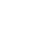

In [40]:
from IPython.display import display, Image

display(Image("execution_plan.png.png"))